# Often times, you might be missing dynamic data field along a track, or the data may be unreliable.

# This is particularly true with Speeds, Accelerations, Coursings, Turning Rates, etc.

# These can be derived from the spatiotemporal points if you need to replace/create them.

In [83]:
import trackio as tio
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [40]:
#define raw data files
data_path = './files'
files = glob.glob(f'{data_path}/*clipped_to_polygon*.csv')

In [41]:
#create the Dataset
ds = tio.read(raw_files=files,
              data_path='example00')


No dataset.db found in c:\code\trackio\notebooks\example00. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



In [42]:
#split the raw point data by agents
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     data_cols=['Time',
                                'X',
                                'Y',
                                'Coursing',
                                'Speed'],
                     prefix='Vessel_',
                     ncores=4)

Grouping points: 100%|██████████| 1/1 [00:00<00:00, 667.25it/s]

In [43]:
#split using spatiotemporal thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*24, #time in seconds
                                    distance=0.5, #distance in CRS units (degrees here)
                                    ncores=4)

ds

Splitting tracks using spatiotemporal threshold: 100%|██████████| 163/163 [00:02<00:00, 60.46it/s]


Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    163 Split Agent Files
Static Data Fields:
    []
Dynamic Data Fields:
    ['X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example00

In [44]:
#refresh the metadata
ds = ds.refresh_meta(ncores=4)

Refreshing metadata:   0%|          | 0/163 [00:00<?, ?it/s]

Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 72.32it/s]  


New meta/databases saved to c:\code\trackio\notebooks\example00


# Reprojecting CRS

In [45]:
#get original track
original = ds.get_track(ds.tracks.index[10])

#reproject to another CRS
ds = ds.reproject_crs(3857, ncores=4)

#get reprojected track
reprojected = ds.get_track(ds.tracks.index[10])


Reprojecting CRS: 100%|██████████| 163/163 [00:02<00:00, 69.13it/s]


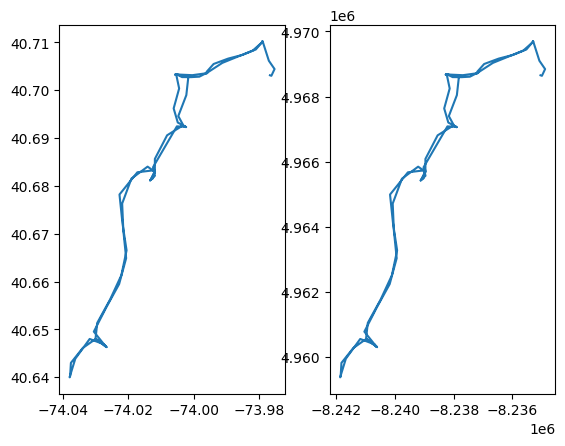

In [46]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'])
ax[1].plot(reprojected['X'], reprojected['Y'])

# Spatial Resampling

In [51]:
#get original track
original = ds.get_track(ds.tracks.index[3])

#resample spacing
ds = ds.resample_spacing(50,
                         tracks=[ds.tracks.index[3]],
                         ncores=4)

#get resampled track
resampled = ds.get_track(ds.tracks.index[3])

Resampling track spacing: 100%|██████████| 1/1 [00:00<00:00, 587.19it/s]


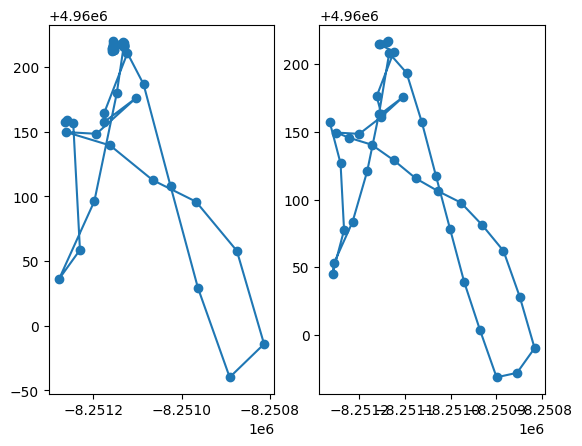

In [53]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[1].plot(resampled['X'], resampled['Y'], '-o')

# Temporal Resampling

In [62]:
#define a track id
track_id = ds.tracks.index[6]

#get original track
original = ds.get_track(track_id)

#check existing temporal resolution
ds.tracks.loc[track_id].filter(like='Temporal')

Min Temporal Resolution            61
Mean Temporal Resolution    64.916667
Max Temporal Resolution            70
Name: Vessel_366939790_T0, dtype: object

In [63]:
#temporal resample
ds = ds.resample_time(30, 
                      tracks=[track_id])

#get resampled track
resampled = ds.get_track(track_id)

Resampling track timing: 100%|██████████| 1/1 [00:00<00:00, 250.59it/s]


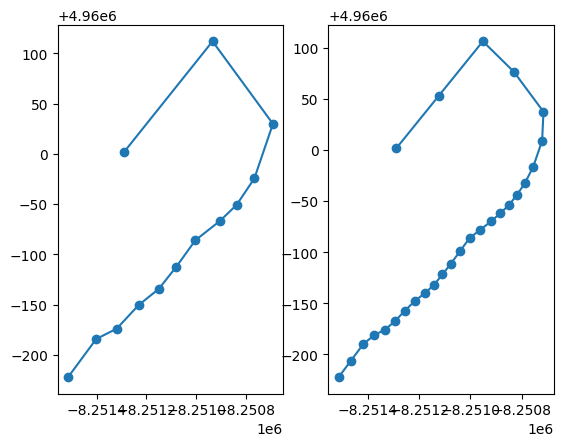

In [64]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[1].plot(resampled['X'], resampled['Y'], '-o')

# You can also do a temporal resample to a global time axis.

# To do this, the time axis must span the times in the entire `Dataset`.

In [69]:
#get time span
tmin = ds.agents['Start Time'].min()
tmax = ds.agents['End Time'].max()

tmin, tmax

(Timestamp('2021-01-01 00:17:12'), Timestamp('2021-01-01 23:59:59'))

In [74]:
#make a new global time axis, 1min intervals
time = pd.date_range('2021-01-01', '2021-01-02', freq='60s')

In [75]:
#temporal resample
ds = ds.resample_time_global(time, 
                             ncores=4)

#refresh meta
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 72.81it/s]


New meta/databases saved to c:\code\trackio\notebooks\example00


# Notice the time axis has been interpolated for all tracks now.

In [77]:
ds.tracks.filter(like='Time').head(5)

,Start Time,End Time
Track ID,,
Vessel_367779550_T0,2021-01-01 00:18:00,2021-01-01 17:38:00
Vessel_367008110_T0,2021-01-01 00:22:00,2021-01-01 23:57:00
Vessel_367549870_T0,2021-01-01 00:18:00,2021-01-01 23:59:00
Vessel_367740750_T0,2021-01-01 00:18:00,2021-01-01 23:59:00
Vessel_368141510_T0,2021-01-01 00:18:00,2021-01-01 23:14:00


In [80]:
ds.get_track(track_id)['Time'].head(5)

0   2021-01-01 20:10:00
1   2021-01-01 20:11:00
2   2021-01-01 20:12:00
3   2021-01-01 20:13:00
4   2021-01-01 20:14:00
Name: Time, dtype: datetime64[ns]

# Coursing Computation

In [96]:
#define a track id
track_id = ds.tracks.index[6]

#get original track
original = ds.get_track(track_id)

In [91]:
#compute the coursing from the points
ds = ds.compute_coursing(tracks=[track_id],
                         method='middle')

Computing coursing: 100%|██████████| 1/1 [00:00<00:00, 161.34it/s]


In [97]:
#get computed track
computed = ds.get_track(track_id)

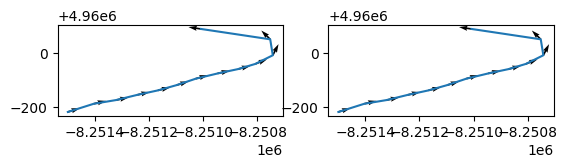

In [100]:
#plot the two
fig, ax = plt.subplots(1, 2)

#original
ax[0].plot(original['X'], original['Y'])
u = np.sin(np.radians(original['Coursing']))
v = np.cos(np.radians(original['Coursing']))
ax[0].quiver(original['X'], original['Y'], u, v)
ax[0].set_aspect('equal')

#computed
ax[1].plot(computed['X'], computed['Y'])
u = np.sin(np.radians(computed['Coursing']))
v = np.cos(np.radians(computed['Coursing']))
ax[1].quiver(computed['X'], computed['Y'], u, v)
ax[1].set_aspect('equal')

# Turning Rate Computation

## This simply uses the coursings, so make sure they're correct or compute them first.

In [120]:
#define a track id
track_id = ds.tracks.index[7]

#get original track
original = ds.get_track(track_id)

In [103]:
#compute the turning from the coursings - output is deg/sec
ds = ds.compute_turning_rate(tracks=[track_id],
                             method='middle')

Computing turning rate: 100%|██████████| 1/1 [00:00<00:00, 400.87it/s]


In [121]:
#get computed track
computed = ds.get_track(track_id)

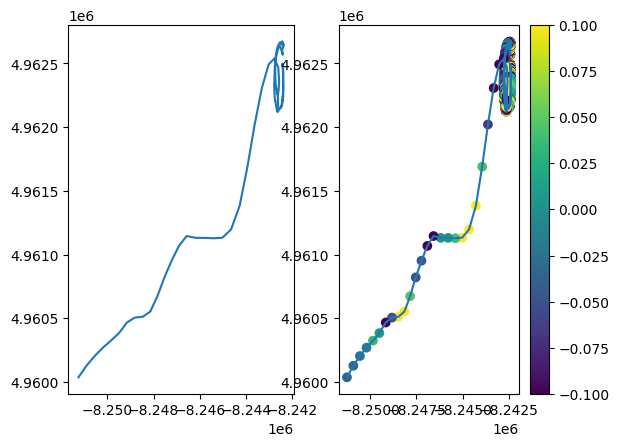

In [122]:
#plot the two
fig, ax = plt.subplots(1, 2)

#original didn't contain turning rate
ax[0].plot(original['X'], original['Y'])

#computed
ax[1].plot(computed['X'], computed['Y'])
m = ax[1].scatter(computed['X'], computed['Y'], c=computed['Turning Rate'], vmin=-0.1, vmax=0.1)
fig.colorbar(m)

# Speed Computation


In [123]:
#define a track id
track_id = ds.tracks.index[10]

#get original track
original = ds.get_track(track_id)

In [124]:
#compute the speed - units is CRS xy units per second (e.g. m/s, deg/s)
ds = ds.compute_speed(tracks=[track_id],
                      method='middle')

Computing speed: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


In [125]:
#get computed track
computed = ds.get_track(track_id)

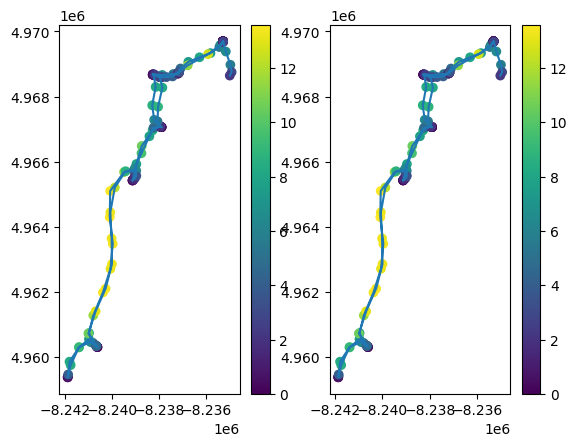

In [127]:
#plot the two
fig, ax = plt.subplots(1, 2)

#original
ax[0].plot(original['X'], original['Y'])
m = ax[0].scatter(original['X'], original['Y'], c=original['Speed'])
fig.colorbar(m)

#computed
ax[1].plot(computed['X'], computed['Y'])
m = ax[1].scatter(computed['X'], computed['Y'], c=computed['Speed'])
fig.colorbar(m)

# Acceleration Computation

## This simply uses the speeds, so make sure they're correct or compute them first.

In [128]:
#define a track id
track_id = ds.tracks.index[7]

#get original track
original = ds.get_track(track_id)

In [ ]:
#compute the acceleration
ds = ds.compute_acceleration(tracks=[track_id],
                             )